<a href="https://colab.research.google.com/github/adarsh1chand/Quantum-Reservoir_Computing/blob/main/Quantum_Reservoir_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Reservoir Computing (Exploratory notebook using Pennylane)

In [2]:
# requirements
!pip install --quiet pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 42.3 MB/s eta 0:00:00


In [3]:
import pennylane as qml

import pennylane.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy

# Set the seed
np.random.seed(42)

### Generating synthetic time-series data to play-around

In [31]:
def generate_synthetic_time_series_data(num_data_points: int = 2000,
                                        random_fluctuation_scale: float = 1.0,
                                        start_date: str = '2017-08-11'):
    """Generate synthetic time-series data"""

    dates = pd.date_range(start = start_date, periods = num_data_points)
    values = np.random.randn(num_data_points).cumsum() + random_fluctuation_scale * np.random.rand()
    return dates, values

def plot_time_series(dates,
                     values,
                     xlabel: str = 'Date',
                     ylabel: str = 'Value',
                     title: str = 'Synthetic time-series data'):

    """Plot the time-series data"""
    plt.plot(dates, values)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation = 45)
    plt.title('Synthetic time-series data')
    plt.show()

def normalize(values: np.array):
    """Normalize all values in an array with mean 0 and standard deviation of 1."""

    values = deepcopy(values)
    return (values - np.mean(values)) / np.std(values)

def scale(values: np.array):
    """Scale all values in an array between 0 and 1"""

    values = deepcopy(values)
    max_abs_value = max([abs(val) for val in values])
    values = values / max_abs_value

    # Check if minimum value in the values is less than zero
    if min(values) < 0:
      # change the scale from [-1, 1] to [0, 1]
      return (1 + values) / 2

    # Else just return the values
      return values

def normalize_and_scale(values: np.array):
    """Normalize and scale all the values in an array."""

    values = deepcopy(values)
    values = normalize(values)
    return scale(values)


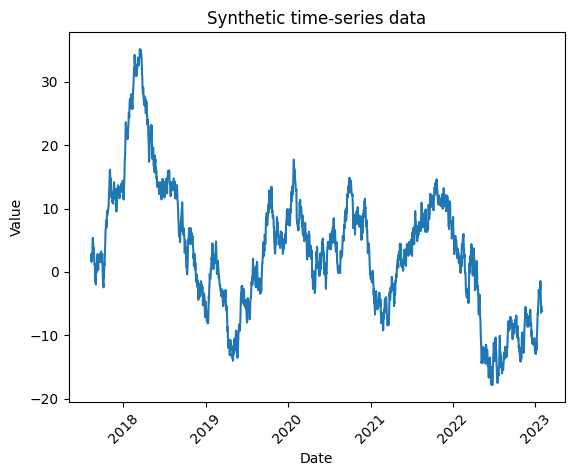

In [32]:
dates, values = generate_synthetic_time_series_data()
plot_time_series(dates, values)

### Constructing the Quantum Reservoir
We will consider the Ising Hamiltonian with only $X-X$ type interactions between all the qubits as our quantum reservoir, i.e. the Hamiltonian looks like:
$$
\begin{align}
    &\hat{H} = h\sum_{i = 0}^{N}\sigma_{z}^{(i)} + \sum_{i \neq j}J_{ij}\sigma_{x}^{(i)}\sigma_{x}^{(j)}
\end{align}
$$

where, $N$ is the number of qubits in the spin glass system, $2h$ is the single-qubit energy which is same for all qubits and $J_{ij}$ is the coupling strength of the $X-X$ interaction between qubits $i$ and $j$.


In [194]:
N = 6 # Number of qubits in the spin glass system
single_qubit_energy = 0.1  # single qubit energy in the excited state.

coupling_matrix = np.random.rand(N, N) # Matrix containing the coupling constants between the qubits of the X-X type interaction terms
coupling_matrix = 1 - (np.transpose(coupling_matrix) + coupling_matrix)   # Making the coupling matrix symmetric and values between [-1, 1]
for i in range(N):          # Setting the diagonal terms to zero in the coupling matrix
  coupling_matrix[i, i] = 0.0

In [195]:
initial_eigen_values, initial_eigen_vector_matrix = np.linalg.eigh(coupling_matrix)  # Eigenvalues and eigenvectors of the copuling matrix
initial_J_0 = max([abs(eigval) for eigval in initial_eigen_values]) # Maximum absolute value of all the eigenvalues of the coupling matrix
                                                                    # (The spectral radius of the coupling or the coupling strength)
single_qubit_coefficients = [0.5 * single_qubit_energy] * N
single_qubit_observables = [qml.PauliZ(i) for i in range(N)]

coupling_matrix_triu = np.triu(coupling_matrix, k = 1)
interaction_coefficients =  list(2 * np.array(coupling_matrix_triu[np.triu(np.ones(coupling_matrix_triu.shape), k=1).astype(bool)].tolist()))
interaction_observables = []
for i in range(N):
  for j in range(N):
    if i < j:
      interaction_observables.append(qml.PauliX(i) @ qml.PauliX(j))

In [196]:
# Forming the spin-glass Hamiltonian operator (Quantum reservoir operator)
reservoir_hamiltonian = qml.Hamiltonian(single_qubit_coefficients + interaction_coefficients, single_qubit_observables + interaction_observables)
print(reservoir_hamiltonian)

  (0.05) [Z0]
+ (0.05) [Z1]
+ (0.05) [Z2]
+ (0.05) [Z3]
+ (0.05) [Z4]
+ (0.05) [Z5]
+ (-1.389481949379367) [X0 X4]
+ (-1.0021552972648324) [X1 X2]
+ (-0.862900183153104) [X3 X5]
+ (-0.7536582394146611) [X4 X5]
+ (-0.6561704670826263) [X2 X3]
+ (-0.4394834493053379) [X0 X5]
+ (-0.2175844637999993) [X0 X3]
+ (-0.058572550294298864) [X3 X4]
+ (0.03758313358159704) [X1 X5]
+ (0.13737282988054145) [X0 X1]
+ (0.5365916135756243) [X0 X2]
+ (0.5684852202934827) [X2 X5]
+ (0.6047573029519078) [X2 X4]
+ (0.7565046686641004) [X1 X3]
+ (1.1744274924325593) [X1 X4]


### Data pre-processing
We will normalize and scale all the values in the time-series data between [0, 1] so that the values can be loaded into the quantum state of input qubit.

The input state to the reservoir is provided after every $T$ time steps and the loading of the input can be represented by the Completely Positive-Trace Preserving (CPTP) map as follows:
$$
\begin{align}
  \rho \rightarrow |\psi_{s_{k}}\rangle\langle\psi_{s_{k}}| \otimes \text{Tr}_{1}[\rho]
\end{align}
$$

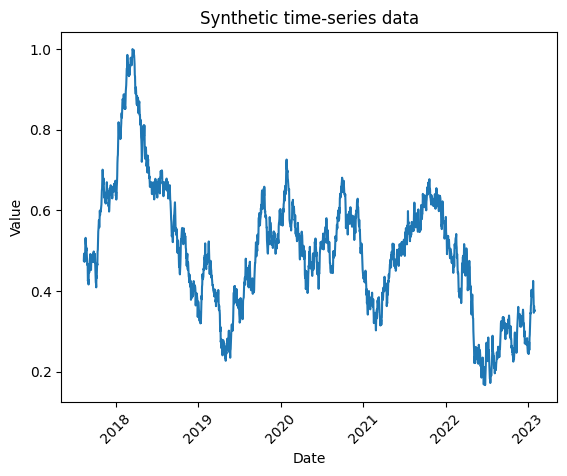

In [197]:
values = normalize_and_scale(values)
plot_time_series(dates, values)

In [198]:
def prepare_input_state_matrix(s_k: float,
                        partial_rho: np.array = None):
  """
  Function which calculates the density in which the input register needs to be prepared.
  """

  if partial_rho is None:
    partial_rho = np.zeros(shape = (2 ** (N - 1), 2 ** (N - 1)))
    partial_rho[0, 0] = 1

  input_state_vector = np.array([[np.sqrt(1 - s_k)], [np.sqrt(s_k)]])
  first_qubit_density_matrix = np.kron(input_state_vector, np.transpose(input_state_vector))
  return first_qubit_density_matrix
  #return np.kron(first_qubit_density_matrix, partial_rho)

def prepare_input_state(s_k: float,
                              partial_rho: np.array = None):
  """"Prepares the input register by loading the value at instant 'k', i.e. s_k into the
      the first qubit and initializing the rest of the qubits in the state $\text{Tr}_{1}[\rho]
      which is just the density matrix obtained from previous iteration's ((k-1) instant) of the
      reservoir evolution and tracing out the first qubit.
  """

  qml.QubitDensityMatrix(prepare_input_state_matrix(s_k, partial_rho), wires = [0])


In [199]:
dev = qml.device("default.mixed", wires = N)

@qml.qnode(dev)
def reservoir_computation(s_k: float,
                          reduced_density_matrix: np.array,
                          evolution_time: float,
                          readout = False):
  prepare_input_state(s_k, reduced_density_matrix)
  qml.ApproxTimeEvolution(reservoir_hamiltonian, time = evolution_time, n = 15)
  if readout:
    return np.array([qml.expval(qml.PauliZ(i)) for i in range(N)])
  else:
    return qml.density_matrix(range(1, N))


In [200]:
def reservoir_forward(s_k,
            input_time = 100,
            readout_time = 10,
            reduced_density_matrix = None
            ):

  reservoir_outputs = []


  # Prepare the input qubit by loading s_k into it's state and then let the reservoir evolve for
  #`input_time / readout_time. After every `readout_time` iterations take the measurement of `PauliZ`
  # on all the qubits which will be the output from the reservoir. Multiply the averaged output from the reservoir
  # for `readout_time` many instances by the weight vector to get the prediction of the next instant.
  # After every `input_time `many iterations, pass in the next s_k and the reduced density matrix of all qubits
  # except the input qubit of the previous iteration


  reservoir_output = np.zeros(shape = (1, N))

  for iteration in range(int(input_time / readout_time)):
      # Evolve for readout_time
      reservoir_output += reservoir_computation(s_k,
                                                reduced_density_matrix,
                                                evolution_time = (iteration + 1) * readout_time,
                                                readout = True)

  # Take the reduced density matrix of all qubits except the first qubit to be used in the next iteration
  reduced_density_matrix = reservoir_computation(s_k,
                                                 reduced_density_matrix,
                                                 evolution_time = input_time,
                                                 readout = False)

  # Average over all the readout times to get the final prediction
  return (reservoir_output / (int(input_time / readout_time))).reshape(-1, ), reduced_density_matrix

In [203]:
def QRC_predict(X,
                num_steps_in_future: int = 100,
                model = None,
                memory = False,
                train = False):

    predictions = []

    if train is False:
        pred = X[0]

        for step in range(num_steps_in_future):

            if step % 10 == 0:
                print("Reservoir output for {} step".format(step))

            reservoir_output, memory = reservoir_forward(s_k = pred,
                                                        reduced_density_matrix = memory)


            pred = model.predict([reservoir_output])
            predictions.append(pred)

        return predictions

    else:
        for step, s_k in enumerate(X):

            if step % 10 == 0:
              print("Reservoir output for {} step".format(step))

            reservoir_output, memory = reservoir_forward(s_k = s_k,
                                                         reduced_density_matrix = memory)

            predictions.append(reservoir_output)

        return predictions, memory

In [204]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model = LinearRegression()

In [ ]:
X_train, _ = QRC_predict(values[: 500], train = True)
model.fit(X_train, values[1: 501])

In [ ]:
reservoir_preds, memory = QRC_predict(values[500: 1000], train = True)
y_pred = model.predict(reservoir_preds)
plt.plot(dates[500 : 1000], values[501: 1001])
plt.plot(dates[500 : 1000], y_pred)
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('Output from reservoir multiplied by trained weights (after training) vs Ground Truth (seen data)')
plt.show()

In [ ]:
y_pred = QRC_predict(X = [values[1000]],
                    num_steps_in_future = 200,
                    memory = memory,
                    model = model, train = False)
plt.plot(dates[1001 : 1201], values[1001: 1201])
plt.plot(dates[1001 : 1201], y_pred)
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('New output generated by the reservoir computer after training vs the Ground Truth (unseen data)')
plt.show()

In [ ]:
y_pred = []
initial_input = values[501]
for i in range(1000):
  print("Prediction {} done...".format(i))
  pred = model.predict([forward([initial_input])])
  y_pred.append(pred)
  initial_input = pred
  print(end = "\r")
print("R2 score: ", r2_score(values[501: 1501], y_pred))

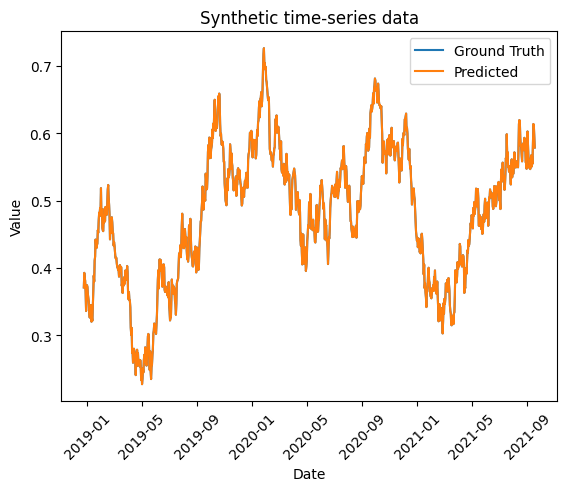

In [95]:
plt.plot(dates[500: 1500], values[500: 1500])
plt.plot(dates[500: 1500], y_pred)
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('Synthetic time-series data')
plt.show()

Reservoir computer output for 0 values....✓
Reservoir computer output for 10 values....✓
Reservoir computer output for 20 values....✓
Reservoir computer output for 30 values....✓
Reservoir computer output for 40 values....✓
Reservoir computer output for 50 values....✓
Reservoir computer output for 60 values....✓
Reservoir computer output for 70 values....✓
Reservoir computer output for 80 values....✓
Reservoir computer output for 90 values....✓
Reservoir computer output for 100 values....✓
Reservoir computer output for 110 values....✓
Reservoir computer output for 120 values....✓
Reservoir computer output for 130 values....✓
Reservoir computer output for 140 values....✓
Reservoir computer output for 150 values....✓
Reservoir computer output for 160 values....✓
Reservoir computer output for 170 values....✓
Reservoir computer output for 180 values....✓
Reservoir computer output for 190 values....✓
Reservoir computer output for 200 values....✓
Reservoir computer output for 210 values....✓

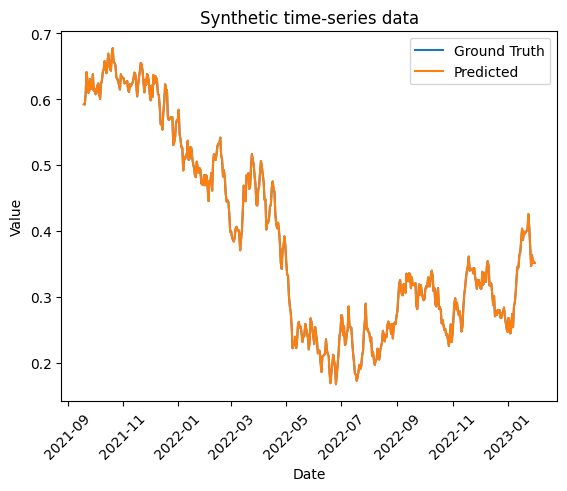

In [96]:
plt.plot(dates[1500: ], values[1500: ])
plt.plot(dates[1500: ], model.predict(forward(values[1500: ])))
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('Synthetic time-series data')
plt.show()

In [117]:
upper_triangular = np.array([[0, 2, 3],
                             [0, 0, 6],
                             [0, 0, 0]])

# Get the upper triangular elements (excluding diagonal)
upper_triangular_elements = upper_triangular[np.triu(np.ones(upper_triangular.shape), k=1).astype(bool)]

# Convert the upper triangular elements to a list
upper_triangular_list = upper_triangular_elements.tolist()
upper_triangular_list

[2, 3, 6]

In [83]:
def tune_spectral_radius(new_j_0 : int) -> np.ndarray:
  """
  Given a spectral radius value, it scales all the eigen values of the coupling matrix by this value,
  keeping the eigenvectors fixed.

  Parameters
  ----------

  new_j_0: New spectral radius

  Returns
  -------
  np.ndarray: The new coupling matrix

  """
  new_eigen_values = initial_eigen_values / initial_J_0
  new_eigen_values *= new_j_0

  return initial_eigen_vector_matrix @ np.diag(new_eigen_values) @ np.transpose(initial_eigen_vector_matrix)
